# **Machine Maintenance Predictor**

## **Imports**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os 
import kaggle
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from zlib import crc32
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import time
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from keras import regularizers
from keras import activations
from keras.layers import BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV

## **Load Data From Kaggle**

We are using the "Machine Predictive Maintenance Classification" dataset from "https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification"

In [3]:
kaggleDataset = "shivamb/machine-predictive-maintenance-classification"
datasetPath = os.path.join("dataset", "Predictive Maintenance")

In [4]:
# Check if the dataset folder already exists
if os.path.exists(datasetPath):
    download = input("The dataset may already be downloaded. Do you want to download and replace it? (Y/N): ").strip().upper()
    if download == 'Y':
        kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
        print("Dataset downloaded and unzipped.")
    else:
        print("Skipping download.")
else:
    # Download if the dataset folder doesn't exist
    kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)
    print("Dataset downloaded and unzipped.")

Skipping download.


In [5]:
def loadPredictiveMaintenance(datasetPath = datasetPath):
    csvPath = os.path.join(datasetPath, "predictive_maintenance.csv")
    return pd.read_csv(csvPath, engine='python', on_bad_lines='skip')

In [6]:
MaintenanceData = loadPredictiveMaintenance()

## **Feature Descriptions:**
- **UID**: unique identifier ranging from 1 to 10000
- **ProductID**: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- **air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- **process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- **rotational speed [rpm]**: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- **torque [Nm]**: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- **tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.
- **Target**: Failure or Not
- **Failure Type**: Type of Failure

## **Data Wrangling: Converting temperature units and adjusting tool wear time**
Let's do some data wrangling by converting temperature values from Kelvin to Celsius and adjusting the tool wear time from minutes to seconds. We'll also update the column names accordingly.

In [7]:
MaintenanceData["Air temperature [K]"] = MaintenanceData["Air temperature [K]"] - 272.15
MaintenanceData["Process temperature [K]"] = MaintenanceData["Process temperature [K]"] - 272.15
MaintenanceData["Tool wear [min]"] = MaintenanceData["Tool wear [min]"] * 60

MaintenanceData.rename(columns={
    "Air temperature [K]" : "Air temperature [°C]",
    "Process temperature [K]" : "Process temperature [°C]",
    "Tool wear [min]" : "Tool wear [sec]"
    },inplace=True)

MaintenanceData["Temperature difference [°C]"] = MaintenanceData["Process temperature [°C]"] - MaintenanceData["Air temperature [°C]"]

## **Data Exploration: Understanding the dataset structure and summary statistics**
Let's explore the dataset to get a sense of its structure, data types, and basic statistics.

In [8]:
MaintenanceData.head()

UDI Product ID Type  Air temperature [°C]  Process temperature [°C]  \
0    1     M14860    M                 25.95                     36.45   
1    2     L47181    L                 26.05                     36.55   
2    3     L47182    L                 25.95                     36.35   
3    4     L47183    L                 26.05                     36.45   
4    5     L47184    L                 26.05                     36.55   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [sec]  Target Failure Type  \
0                    1551         42.8                0       0   No Failure   
1                    1408         46.3              180       0   No Failure   
2                    1498         49.4              300       0   No Failure   
3                    1433         39.5              420       0   No Failure   
4                    1408         40.0              540       0   No Failure   

   Temperature difference [°C]  
0                         10.5  
1                         10.5  
2                         10.4  
3                         10.4  
4                         10.5

In [9]:
MaintenanceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   UDI                          10000 non-null  int64  
 1   Product ID                   10000 non-null  object 
 2   Type                         10000 non-null  object 
 3   Air temperature [°C]         10000 non-null  float64
 4   Process temperature [°C]     10000 non-null  float64
 5   Rotational speed [rpm]       10000 non-null  int64  
 6   Torque [Nm]                  10000 non-null  float64
 7   Tool wear [sec]              10000 non-null  int64  
 8   Target                       10000 non-null  int64  
 9   Failure Type                 10000 non-null  object 
 10  Temperature difference [°C]  10000 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 859.5+ KB


In [10]:
MaintenanceData.describe()

UDI  Air temperature [°C]  Process temperature [°C]  \
count  10000.00000          10000.000000              10000.000000   
mean    5000.50000             27.854930                 37.855560   
std     2886.89568              2.000259                  1.483734   
min        1.00000             23.150000                 33.550000   
25%     2500.75000             26.150000                 36.650000   
50%     5000.50000             27.950000                 37.950000   
75%     7500.25000             29.350000                 38.950000   
max    10000.00000             32.350000                 41.650000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [sec]        Target  \
count            10000.000000  10000.000000     10000.000000  10000.000000   
mean              1538.776100     39.986910      6477.060000      0.033900   
std                179.284096      9.968934      3819.248798      0.180981   
min               1168.000000      3.800000         0.000000      0.000000   
25%               1423.000000     33.200000      3180.000000      0.000000   
50%               1503.000000     40.100000      6480.000000      0.000000   
75%               1612.000000     46.800000      9720.000000      0.000000   
max               2886.000000     76.600000     15180.000000      1.000000   

       Temperature difference [°C]  
count                 10000.000000  
mean                     10.000630  
std                       1.001094  
min                       7.600000  
25%                       9.300000  
50%                       9.800000  
75%                      11.000000  
max                      12.100000

## **Data Visualization: Gaining insights through distributions, categories, and relationships**
Let's use Seaborn to explore the dataset visually. We'll start by plotting histograms with KDE and boxplots for the numerical features to understand their distributions and spot any outliers. Next, we'll visualize the categorical features using bar plots and pie charts to examine class distributions. Finally, we'll use scatter and relational plots to explore the relationship between torque, rotational speed, and failure types across different machine types.


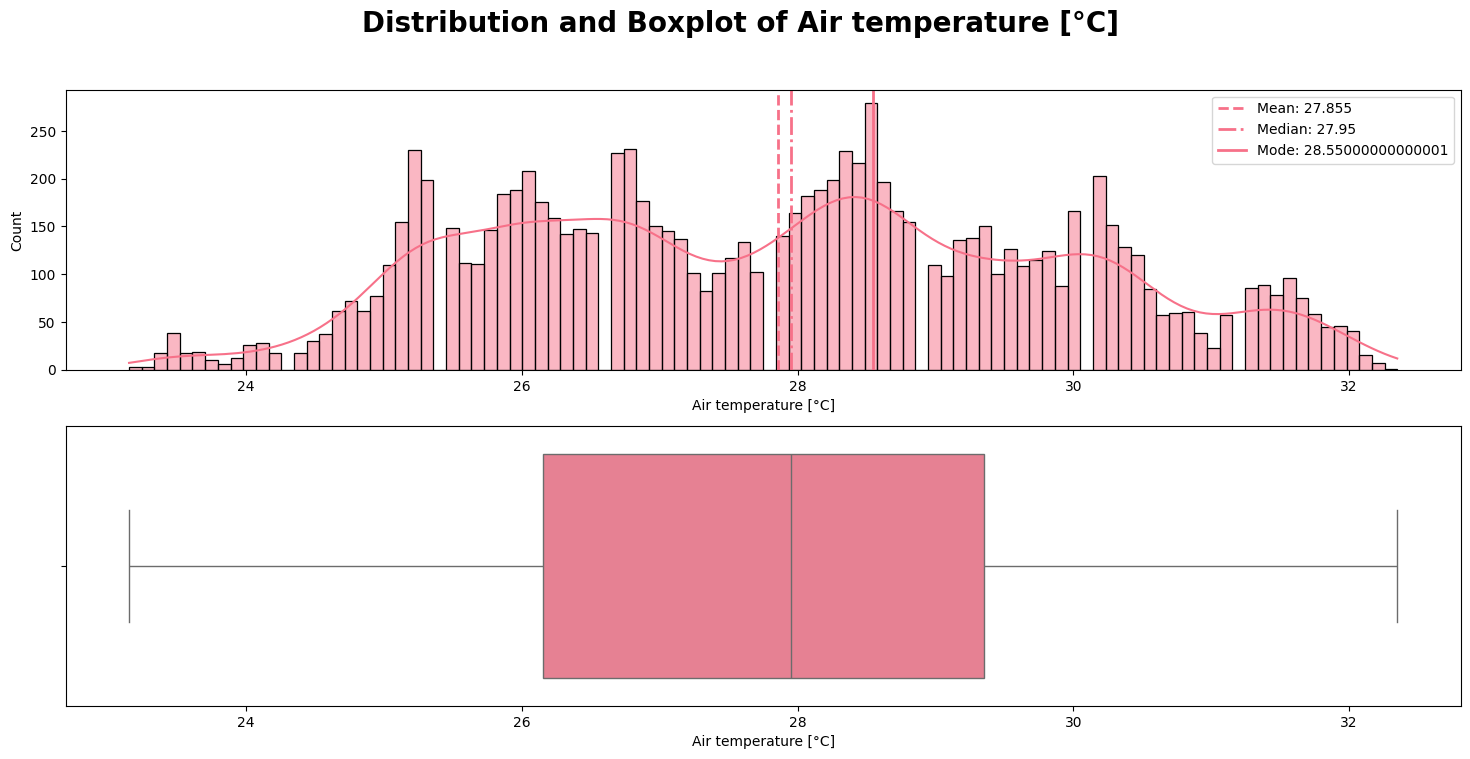

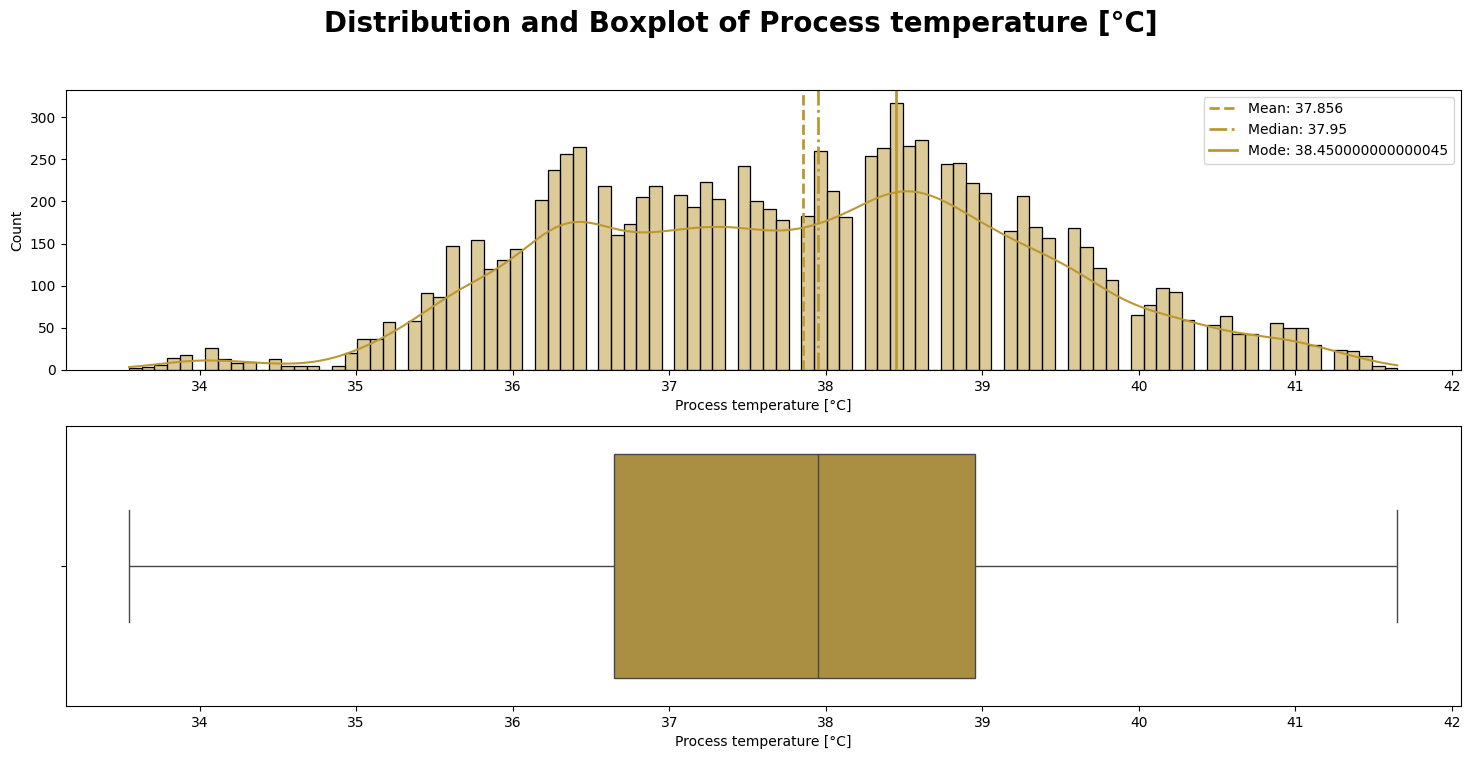

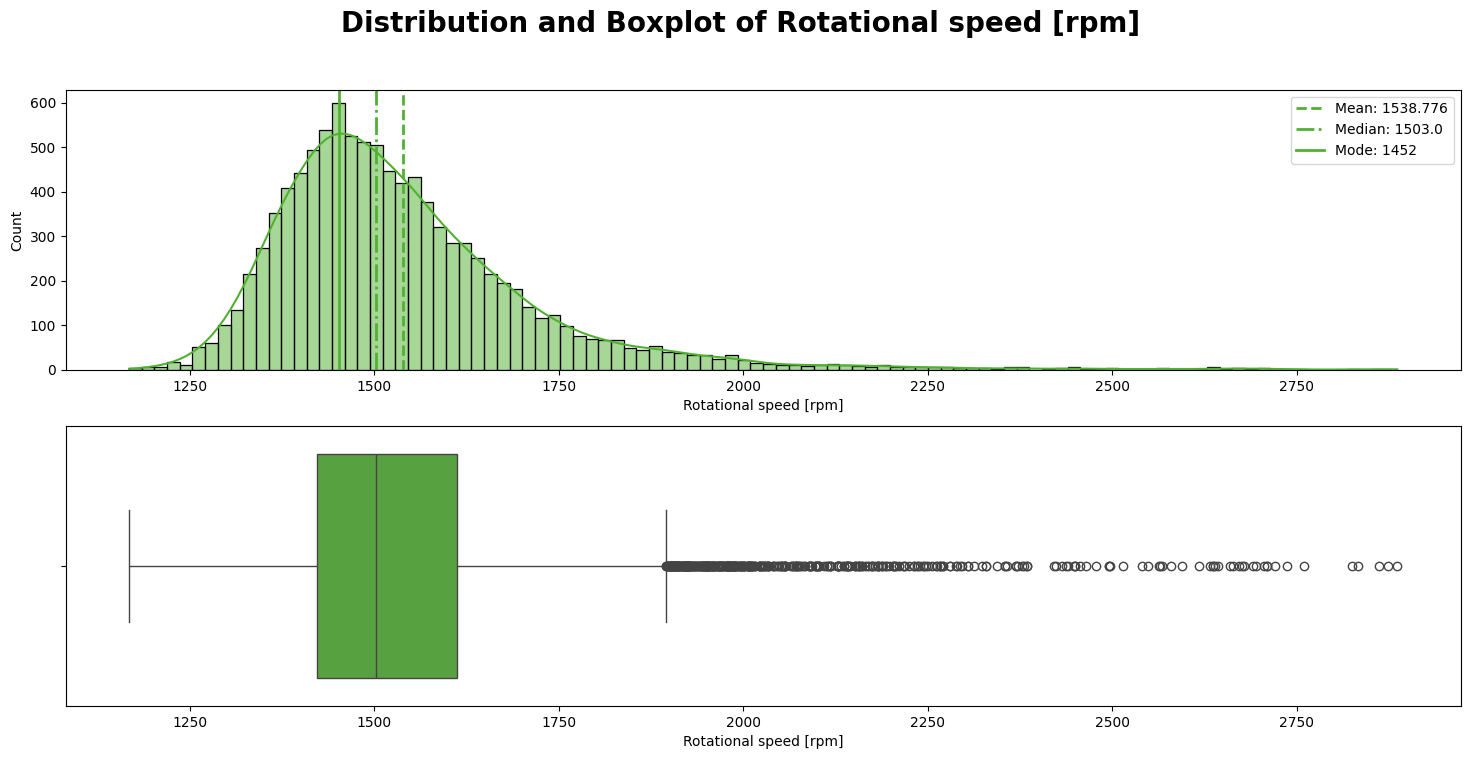

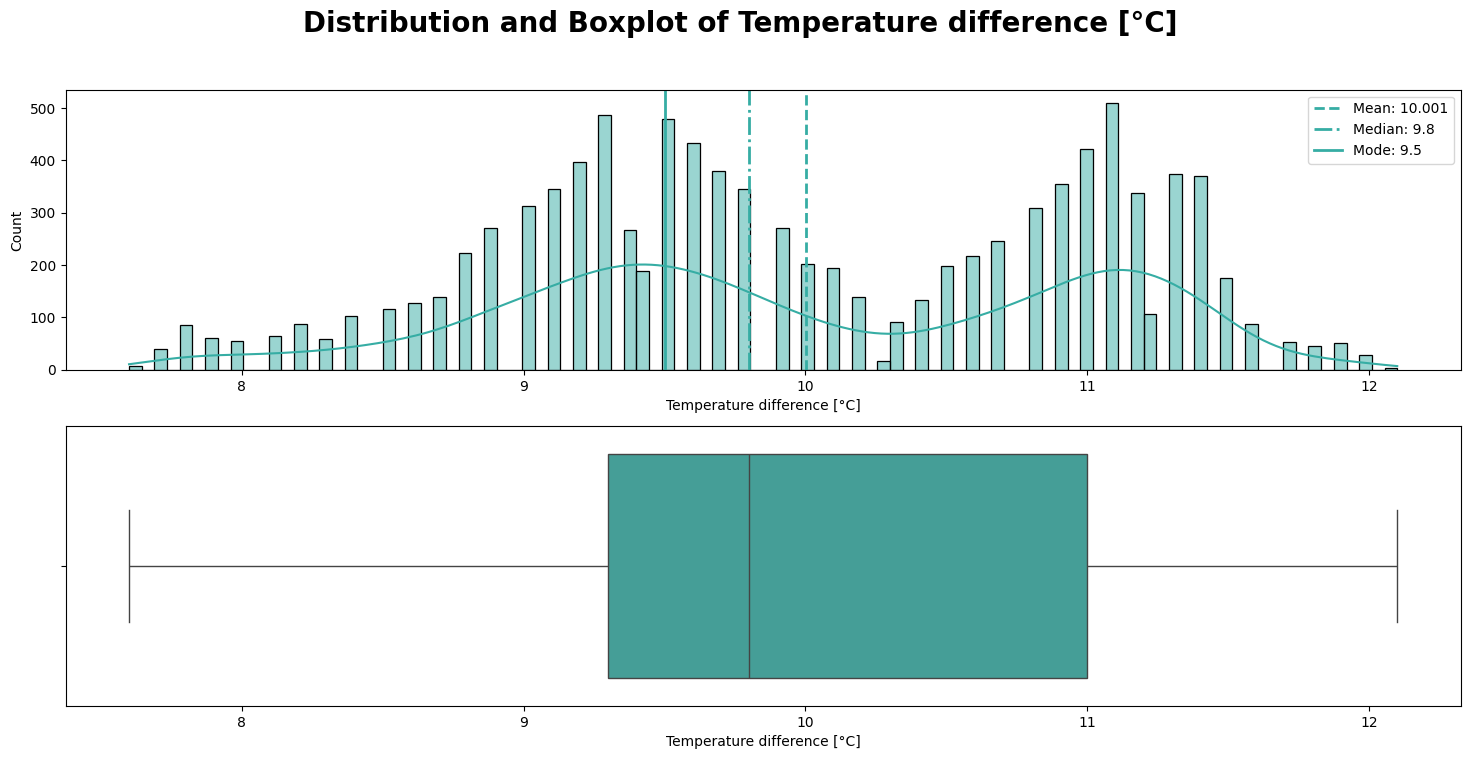

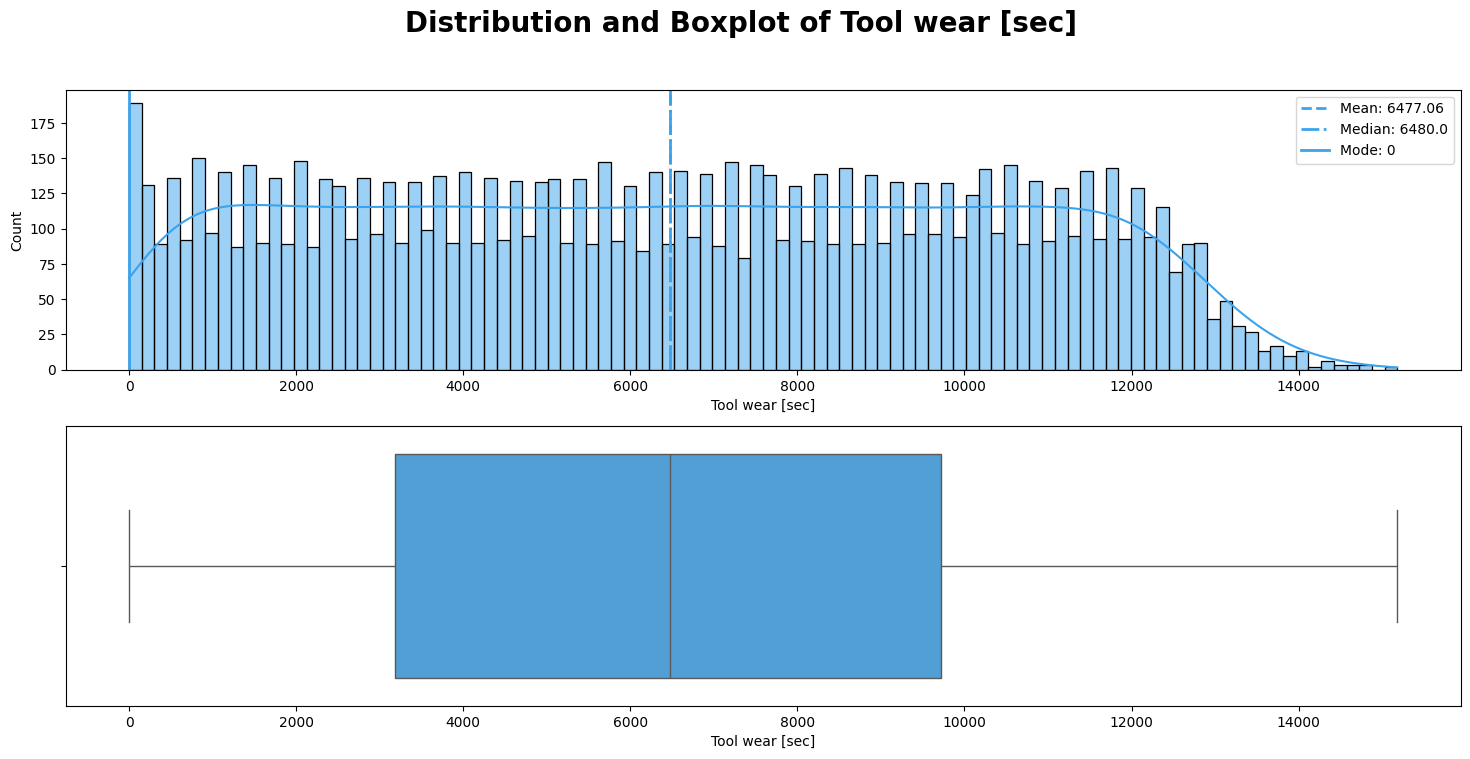

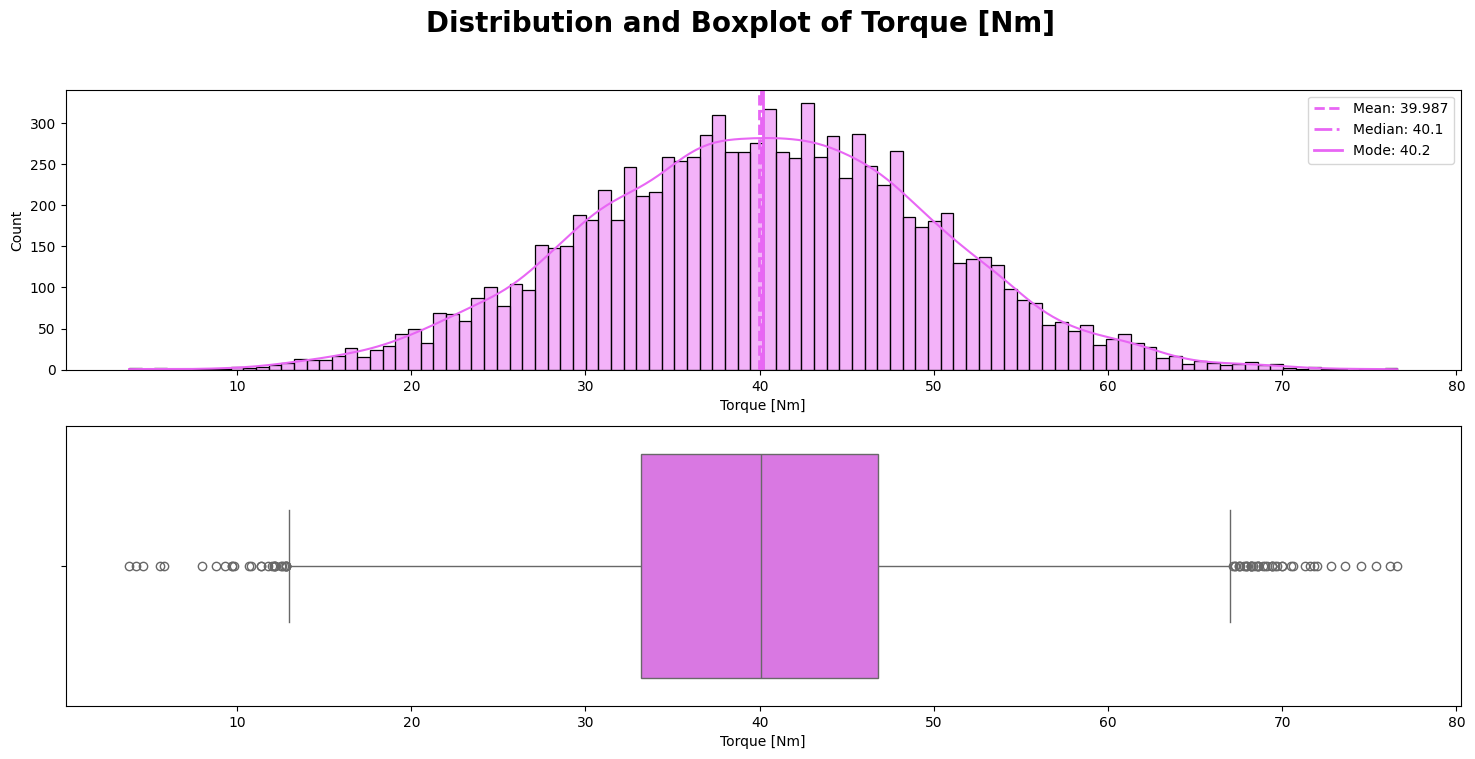

In [11]:
numeric_columns = MaintenanceData.select_dtypes(include=['number']).columns.difference(["UDI", "Target"])

colors = sns.color_palette("husl", len(numeric_columns))

for i, col in enumerate(numeric_columns):
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))

    fig.suptitle(f"Distribution and Boxplot of {col}", fontsize=20, fontweight='bold')

    sns.histplot(data = MaintenanceData[col], kde = True, bins=100, ax = ax[0],color=colors[i])

    ax[0].axvline(x = MaintenanceData[col].mean(), color=colors[i], linestyle = '--', linewidth = 2, label = 'Mean: {}'.format(round(MaintenanceData[col].mean(), 3)))
    ax[0].axvline(x = MaintenanceData[col].median(), color=colors[i], linestyle = '-.', linewidth = 2, label = 'Median: {}'.format(round(MaintenanceData[col].median(), 3)))
    ax[0].axvline(x = statistics.mode(MaintenanceData[col]), color=colors[i], linewidth = 2, label = 'Mode: {}'.format(MaintenanceData[col].mode().iloc[0]))
    ax[0].legend()
    
    sns.boxplot(x = MaintenanceData[col], ax = ax[1],color=colors[i])
    plt.show()

### Takeaways: 
- Rotational speed being skewed to the left may result in it being more influencial in training. This is because any outliers to the right may carry important predictive information.  

Type
L    60.00
M    29.97
H    10.03
Name: proportion, dtype: float64

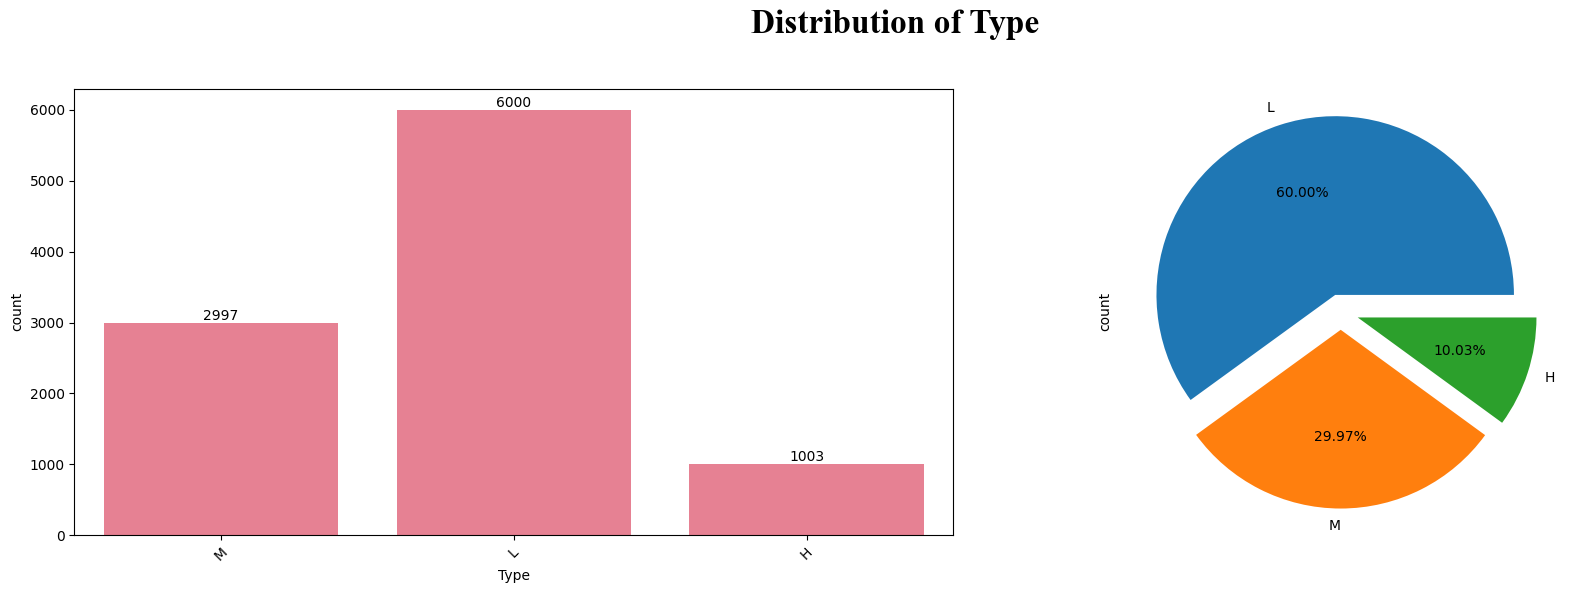

Target
0    96.61
1     3.39
Name: proportion, dtype: float64

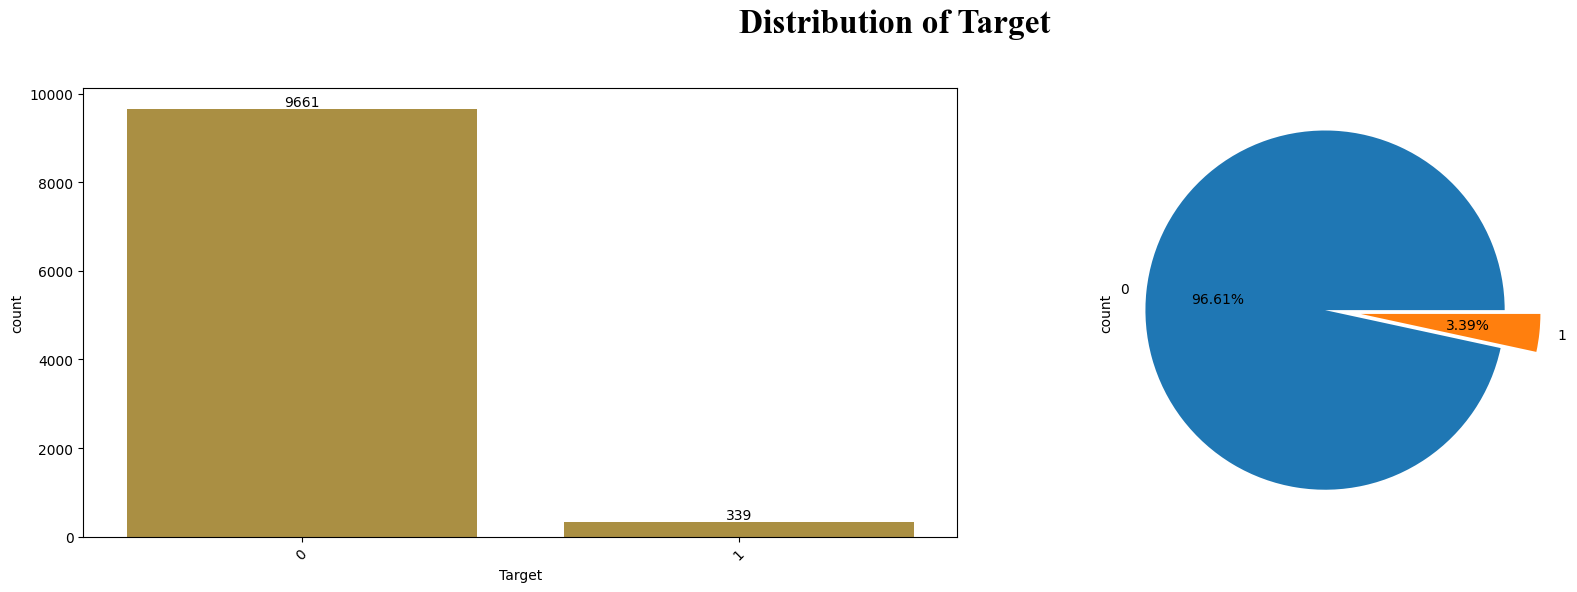

Failure Type
No Failure                  96.52
Heat Dissipation Failure     1.12
Power Failure                0.95
Overstrain Failure           0.78
Tool Wear Failure            0.45
Random Failures              0.18
Name: proportion, dtype: float64

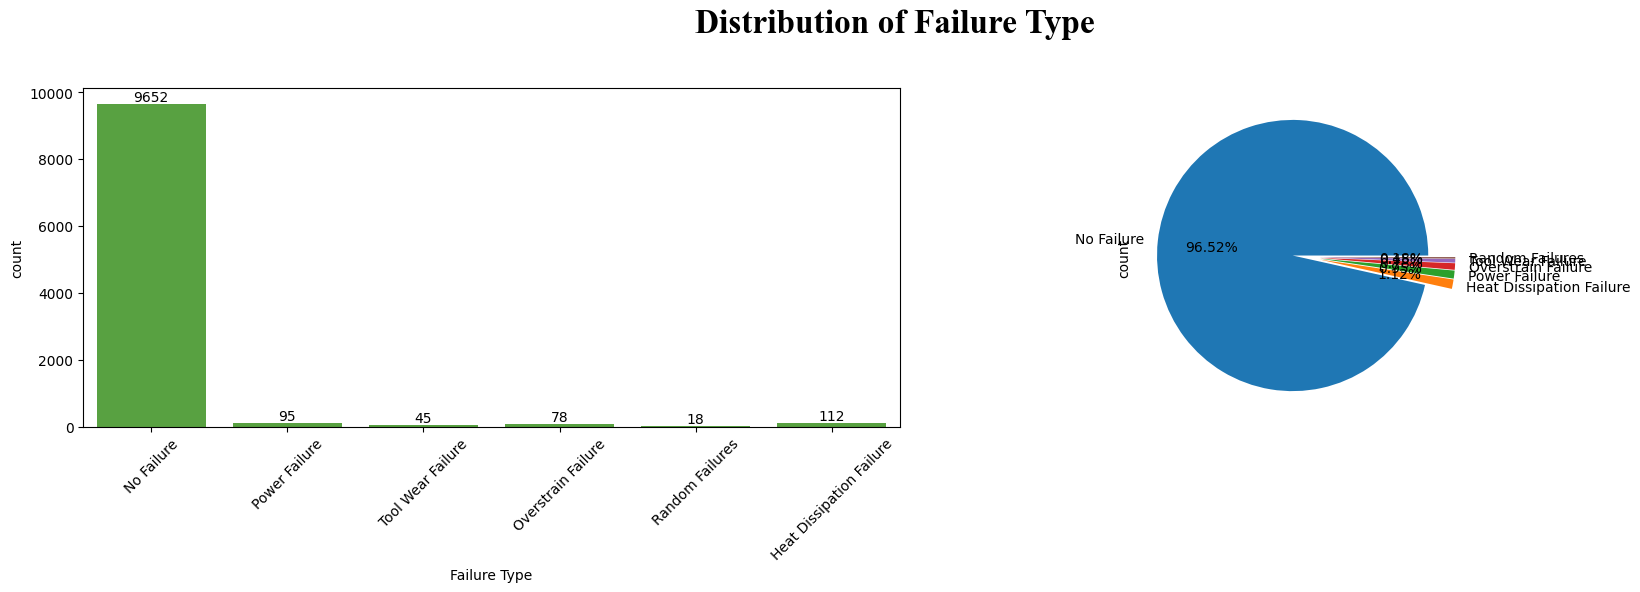

In [12]:
for i, col in enumerate(MaintenanceData[['Type', 'Target', 'Failure Type']].columns):
    Percentage = MaintenanceData[col].value_counts(normalize=True) * 100
    display(Percentage)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  
    fig.suptitle(f"Distribution of {col}", fontsize=24, fontweight='bold', font='Times New Roman', color='black')  
    
    sns.countplot(x=col, data=MaintenanceData, color=colors[i], ax=axes[0])
    axes[0].tick_params(axis='x', rotation=45) 
    axes[0].bar_label(axes[0].containers[0])
    
    counts = MaintenanceData[col].value_counts()
    explode = [0.1] * len(counts)  
    counts.plot.pie(explode=explode, autopct='%1.2f%%', ax=axes[1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show() 


<Axes: xlabel='Torque [Nm]', ylabel='Rotational speed [rpm]'>

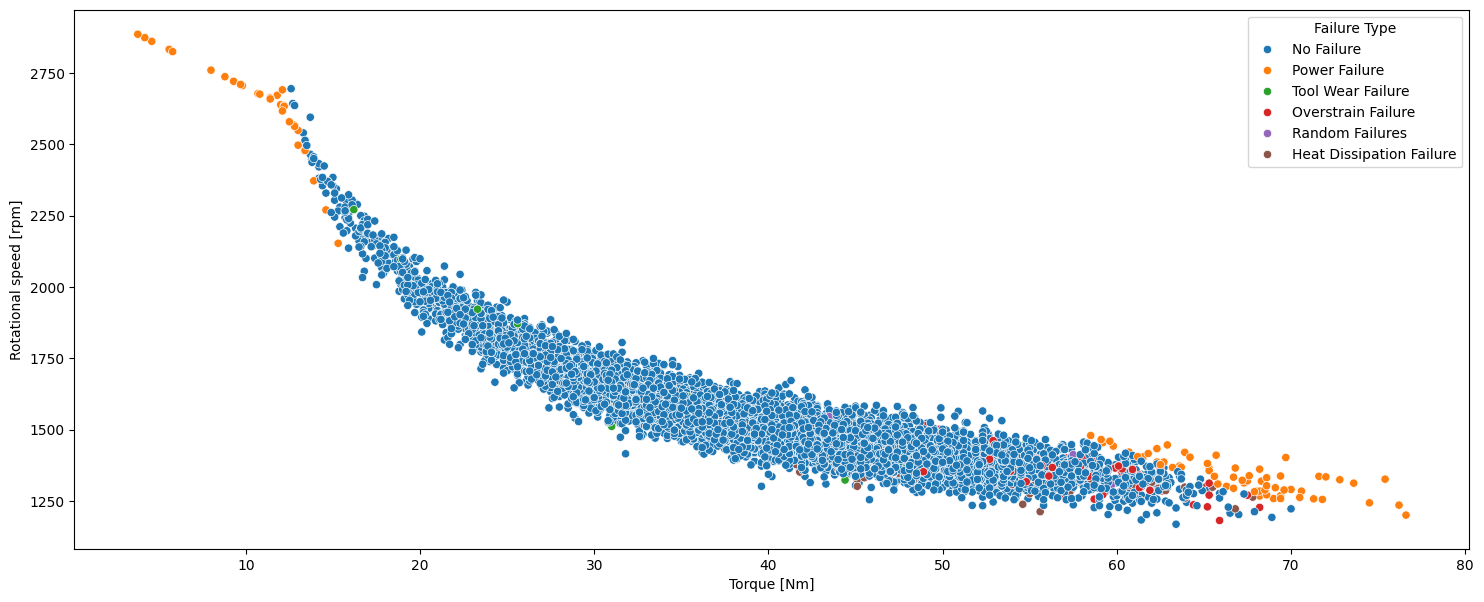

In [13]:
plt.figure(figsize=(18,7))

sns.scatterplot(MaintenanceData, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type", palette="tab10")

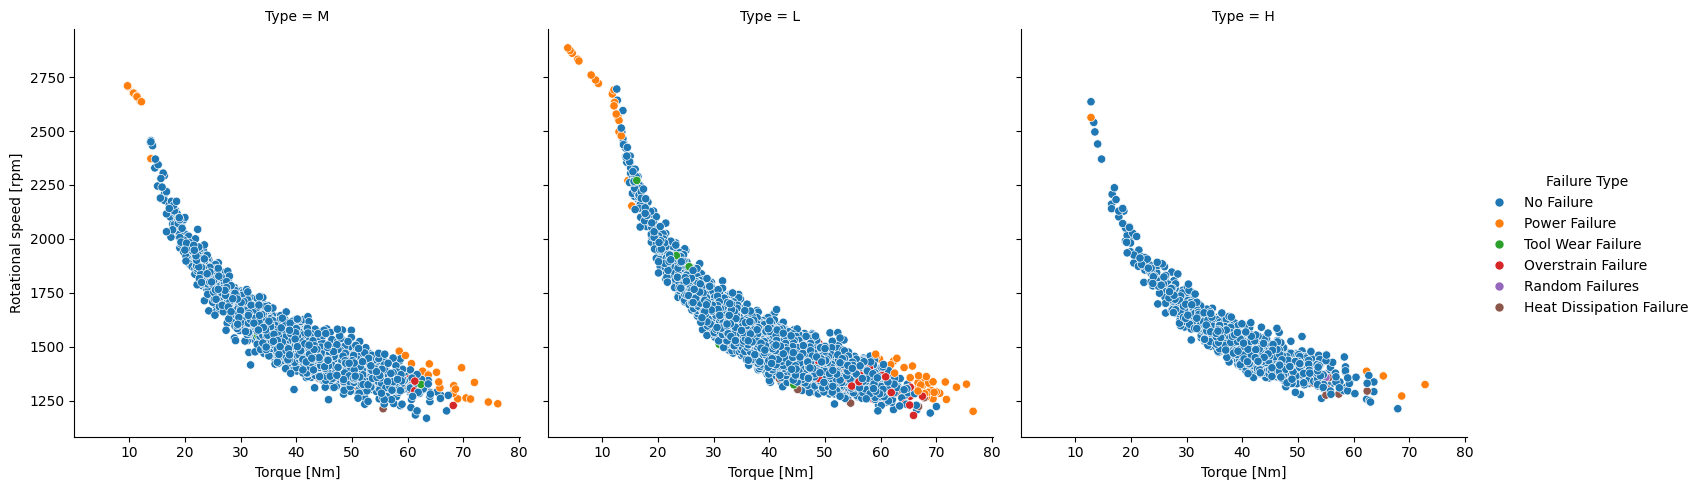

In [14]:
sns.relplot(MaintenanceData, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type", col="Type", palette='tab10')

### Takeaway:
- We can visually see that Torque and Rotational Speed do have a clear relationship with Failure Type. Most failures happen when Torque is low and Rotational Speed is high, and also when Torque is high and Rotational Speed is low. 

We know that `Failure Type` will give us what `Target` gives out but in more detail, so there is no need to predict what `Target` is if `Failure Type` is being predicted already. We can then drop `Target` from our dataset. 

In [15]:
MaintenanceData.drop('Target', axis=1, inplace=True)

We can also factorize our Failure Type, so that it can be a number represented by a separate labels list. 

In [16]:
MaintenanceData['Failure Type'], Failure_Type_labels = pd.factorize(MaintenanceData['Failure Type'])

In [17]:
MaintenanceData.head()

UDI Product ID Type  Air temperature [°C]  Process temperature [°C]  \
0    1     M14860    M                 25.95                     36.45   
1    2     L47181    L                 26.05                     36.55   
2    3     L47182    L                 25.95                     36.35   
3    4     L47183    L                 26.05                     36.45   
4    5     L47184    L                 26.05                     36.55   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [sec]  Failure Type  \
0                    1551         42.8                0             0   
1                    1408         46.3              180             0   
2                    1498         49.4              300             0   
3                    1433         39.5              420             0   
4                    1408         40.0              540             0   

   Temperature difference [°C]  
0                         10.5  
1                         10.5  
2                         10.4  
3                         10.4  
4                         10.5

In [18]:
print(Failure_Type_labels)

Index(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures', 'Heat Dissipation Failure'],
      dtype='object')


## **Creating Train, Valid, and Test Sets**

In order to ensure that our train, valid, and test sets stays consistent no matter how many times we rerun the program or update the dataset, we want to use a unique identifier to help us decide if the row should go into the test set or not. We can compute a hash for each row's unique identifier and use it to split our dataset.

In [19]:
def IDTest(ID):
    return (crc32(np.int64(ID)) & 0xffffffff) / 2**32

def splitTrainValidTestByID(dataset, trainRatio, validRatio, ID):
    assert trainRatio + validRatio < 1, "Train + Validation ratios must be less than 1 (leaving space for test set)."

    IDs = dataset[ID].apply(IDTest)  
    
    trainSet = dataset[IDs < trainRatio]
    validSet = dataset[(IDs >= trainRatio) & (IDs < trainRatio + validRatio)]
    testSet = dataset[IDs >= trainRatio + validRatio]
    
    return trainSet, validSet, testSet

In [20]:
trainSet, validSet, testSet = splitTrainValidTestByID(MaintenanceData, trainRatio=0.7, validRatio=0.15, ID='UDI')

In [21]:
len(trainSet) / len(MaintenanceData) # training set should be 70%

0.6998

In [22]:
len(validSet) / len(MaintenanceData) # training set should be 15%

0.1501

In [23]:
len(testSet) / len(MaintenanceData) # training set should be 15%

0.1501

With our three datasets made, we can drop UDI and Product ID, as we do not want these identifiers affecting our training and results. 

In [24]:
for set_ in (trainSet, validSet, testSet):
    set_.drop('UDI', axis=1, inplace=True)
    set_.drop('Product ID', axis=1, inplace=True)

## **Numerical Feature Analysis: Correlation and Pairwise Relationships**
Let's focus on the numerical features by examining their correlation with the target variable and visualizing pairwise relationships using Seaborn's `pairplot`. This helps identify potential patterns and dependencies among the features with respect to failure types.

In [25]:
train_numeric_attribs = trainSet.select_dtypes(include=['float64', 'int64'])
corr_matrix = train_numeric_attribs.corr()

In [26]:
corr_matrix["Failure Type"].sort_values(ascending=False)

Failure Type                   1.000000
Torque [Nm]                    0.200896
Air temperature [°C]           0.117129
Tool wear [sec]                0.074413
Process temperature [°C]       0.052853
Rotational speed [rpm]        -0.126369
Temperature difference [°C]   -0.155680
Name: Failure Type, dtype: float64

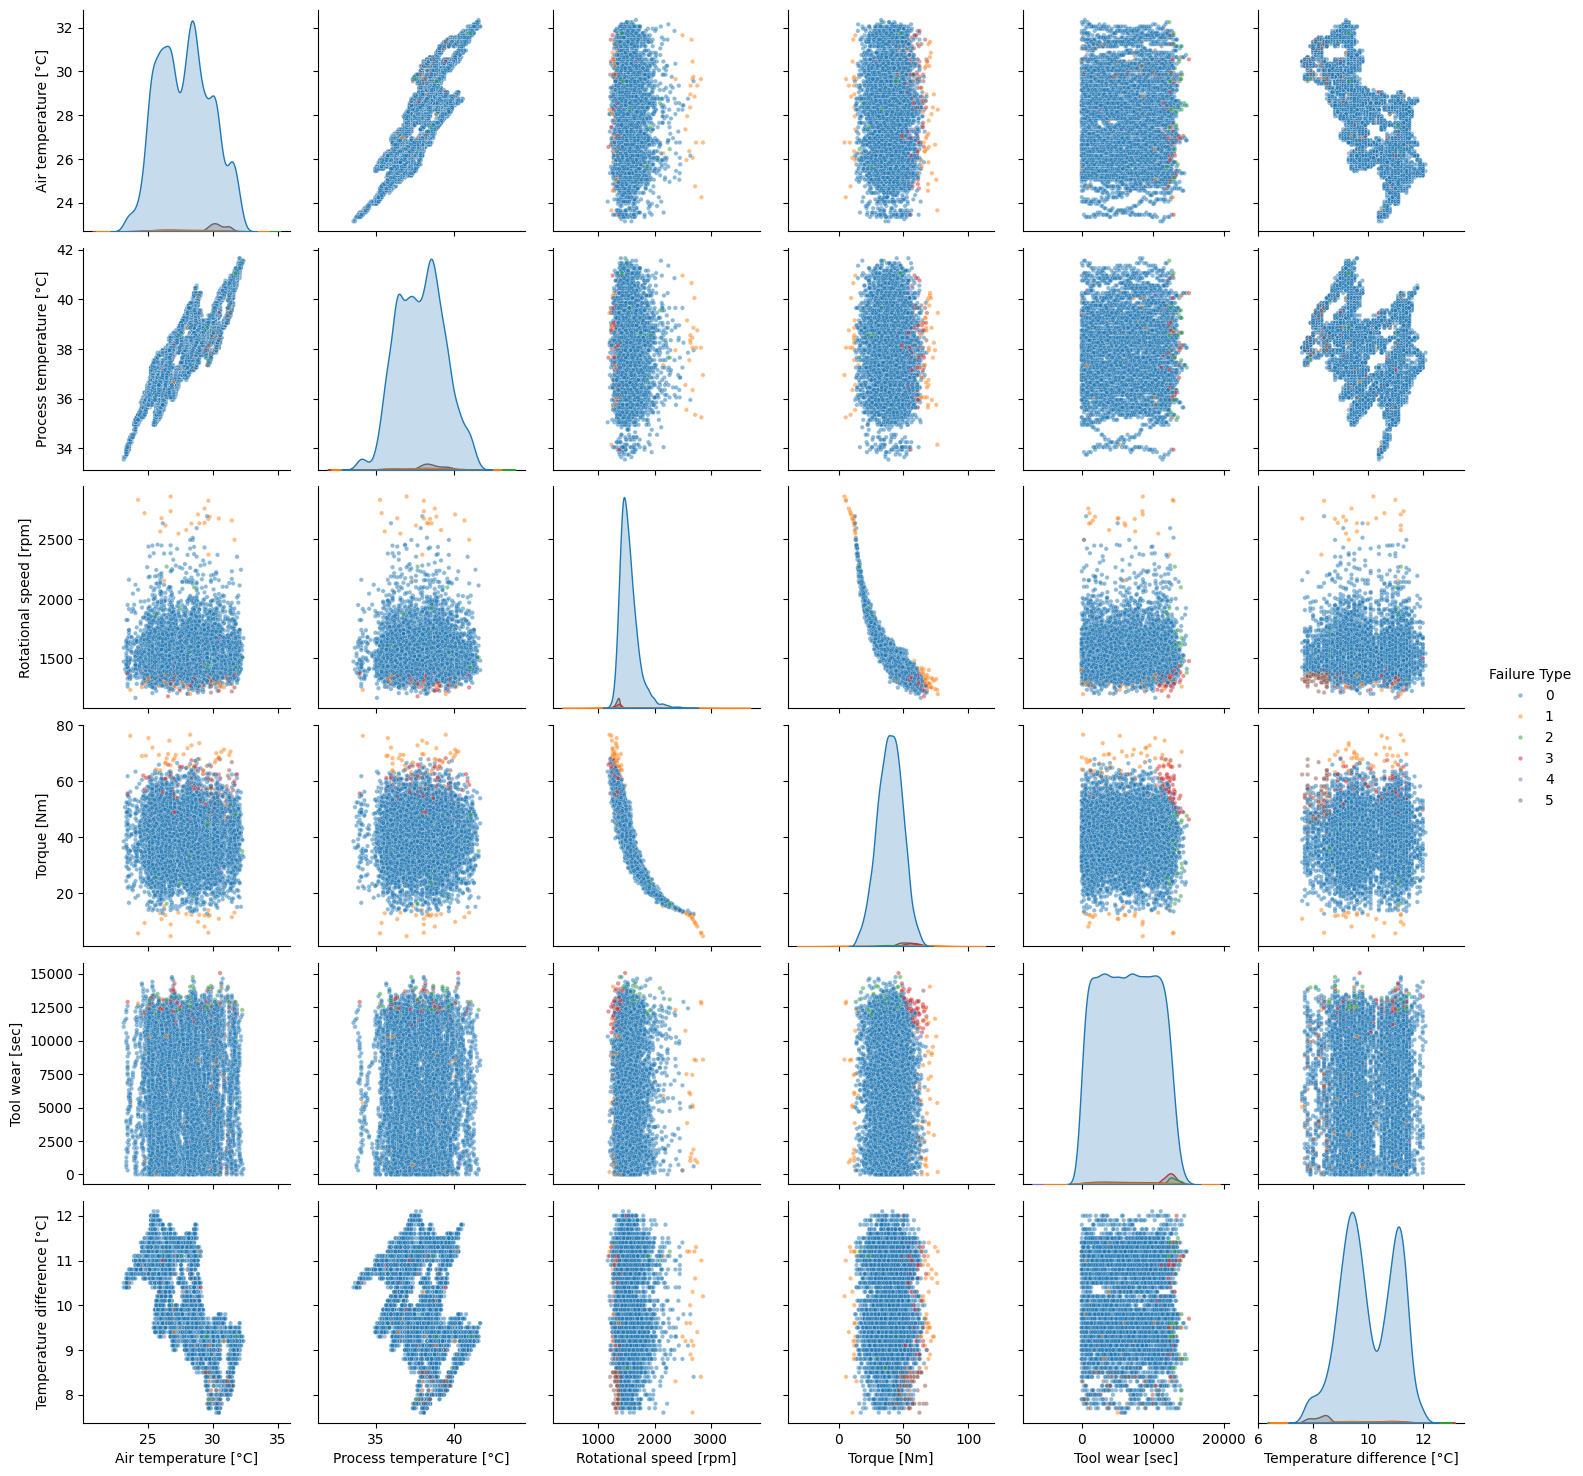

In [27]:
matrix_attributes = trainSet.select_dtypes(include=['number']).columns
sns.pairplot(trainSet[matrix_attributes], diag_kind='kde', hue='Failure Type', palette='tab10', plot_kws={'alpha':0.5, 's':10})
plt.show()

In [28]:
X_train = trainSet.drop(["Failure Type"], axis=1)
y_train = trainSet[["Failure Type"]].copy()

In [29]:
X_train.head()

Type  Air temperature [°C]  Process temperature [°C]  \
0    M                 25.95                     36.45   
1    L                 26.05                     36.55   
4    L                 26.05                     36.55   
5    M                 25.95                     36.45   
6    L                 25.95                     36.45   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [sec]  \
0                    1551         42.8                0   
1                    1408         46.3              180   
4                    1408         40.0              540   
5                    1425         41.9              660   
6                    1558         42.4              840   

   Temperature difference [°C]  
0                         10.5  
1                         10.5  
4                         10.5  
5                         10.5  
6                         10.5

In [30]:
y_train.head()

Failure Type
0             0
1             0
4             0
5             0
6             0

## **Handling Missing Values: Imputing numerical features**
There are no null values for our numeric features, but let's just include a SimpleImputer just in case there is and we can replace them with the median. This ensures we don't have to worry that our model can train effectively without being affected by missing data.

In [31]:
X_train_numeric_attribs = X_train.select_dtypes(include=['float64', 'int64'])

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train_numeric_attribs)

SimpleImputer(strategy='median')

In [32]:
imputer.statistics_

array([  27.95,   37.95, 1504.  ,   40.  , 6480.  ,    9.8 ])

In [33]:
X_train_numeric_attribs.median().values

array([  27.95,   37.95, 1504.  ,   40.  , 6480.  ,    9.8 ])

# **Object Feature: Encoding Categorical Data**
The dataset contains a single object-type feature, `Type`, which represents machine categories: M, L, and H. To make this feature suitable for machine learning models, we can apply one-hot encoding. This transforms `Type` into three binary columns—one for each category—effectively converting the categorical data into a numerical format.

In [34]:
X_train_object_attribs = X_train.select_dtypes(include=['object'])
object_encoder = OneHotEncoder()
X_train_object_attribs_1hot = object_encoder.fit_transform(X_train_object_attribs)
X_train_object_attribs_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6998 stored elements and shape (6998, 3)>

In [35]:
X_train_object_attribs_1hot.toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [36]:
object_encoder.categories_

[array(['H', 'L', 'M'], dtype=object)]

## **Data Transformation Pipelines: Preparing features for modeling** 
Let's create a transformation pipeline to automate the preprocessing of the dataset. We will use a `Pipeline` for numerical features to impute missing values and standardize the data. The `ColumnTransformer` then combines the numerical and categorical transformations, ensuring that both types of features are properly processed for model training.

In [ ]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

X_train_numeric_transformed = numeric_pipeline.fit_transform(X_train_numeric_attribs)

In [38]:
numeric_attribs = list(X_train_numeric_attribs)
object_attribs = list(X_train_object_attribs)

full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_attribs),
    ('objects', OneHotEncoder(handle_unknown='ignore'), object_attribs), 
])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [39]:
display(X_train_prepared[:5])

array([[-0.9522792 , -0.94740685,  0.06014013,  0.2873698 , -1.70161734,
         0.49869479,  0.        ,  0.        ,  1.        ],
       [-0.90232305, -0.88004845, -0.72880455,  0.63672424, -1.6544768 ,
         0.49869479,  0.        ,  1.        ,  0.        ],
       [-0.90232305, -0.88004845, -0.72880455,  0.00788626, -1.56019574,
         0.49869479,  0.        ,  1.        ,  0.        ],
       [-0.9522792 , -0.94740685, -0.63501392,  0.19753581, -1.52876872,
         0.49869479,  0.        ,  0.        ,  1.        ],
       [-0.9522792 , -0.94740685,  0.0987598 ,  0.24744358, -1.48162819,
         0.49869479,  0.        ,  1.        ,  0.        ]])

In [40]:
X_valid = validSet.drop(["Failure Type"], axis=1)
y_valid = validSet[["Failure Type"]].copy()

In [41]:
X_valid_prepared = full_pipeline.fit_transform(X_valid)

In [42]:
X_test = testSet.drop(["Failure Type"], axis=1)
y_test = testSet[["Failure Type"]].copy()

In [43]:
X_test_prepared = full_pipeline.fit_transform(X_test)

## **Building Our ANN Model: Wide and Deep Architecture**
Let's build a Wide and Deep model using Keras. This architecture combines both a deep path, with multiple hidden layers, and a wide path, using input features directly alongside the output from the deep layers. The model is designed to capture both high-level feature interactions and specific feature importance, with a final softmax output for classification.

In [44]:
class WideAndDeepModel(keras.Model):
    def __init__(self, n_hidden=3, n_neurons=[100, 50, 16], **kwargs):
        super().__init__(**kwargs)
        self.n_hidden = n_hidden
        self.n_neurons = n_neurons
        self.kernel_initializer = 'he_normal'
        self.input_shape_value = (9,)
        self.activation_function = LeakyReLU(alpha=0.01)

        # Input Layer
        self.input_layer = keras.layers.InputLayer(input_shape=self.input_shape_value)
        
        # Hidden Layers (Deep Path)
        self.hidden_layers = [
            keras.layers.Dense(n_neurons[i], activation=None, 
                               kernel_initializer=self.kernel_initializer)
            for i in range(n_hidden)
        ]
        
        # Concatenate Layer (Wide Path)
        self.concat = keras.layers.Concatenate()
        
        # Final Hidden Layer
        self.hidden_final = keras.layers.Dense(32, activation=self.activation_function, 
                                               kernel_initializer=self.kernel_initializer)
        
        # Output Layer
        self.target_type_output = keras.layers.Dense(6, activation="softmax", name="target_type_output", 
                                                     kernel_initializer=self.kernel_initializer)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)          
            x = self.activation_function(x) 
        concat = self.concat([inputs, x])
        hidden_final = self.hidden_final(concat)
        output = self.target_type_output(hidden_final)
        
        return output

    def get_config(self):
        config = super().get_config() 
        config.update({
            "n_hidden": self.n_hidden,
            "n_neurons": self.n_neurons
        })
        return config

In [45]:

WaD_model = WideAndDeepModel(
    n_hidden=3,  
    n_neurons=[100, 50, 16]
)

In [46]:
WaD_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [47]:
WaD_model.save("WaD_model.keras")

In [48]:
WaD_model.summary()

Model: "wide_and_deep_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ leaky_re_lu (LeakyReLU)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ target_type_output (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
WaD_model.layers

[<LeakyReLU name=leaky_re_lu, built=True>,
 <InputLayer name=input_layer, built=True>,
 <Dense name=dense, built=False>,
 <Dense name=dense_1, built=False>,
 <Dense name=dense_2, built=False>,
 <Concatenate name=concatenate, built=False>,
 <Dense name=dense_3, built=False>,
 <Dense name=target_type_output, built=False>]

## **Setting Up Logging: Tracking Model Training Runs**
Let's set up logging to track the different training runs of our model. Using the current time, we create a unique directory for each run, ensuring that all logs are organized and saved properly for future analysis and comparisons. We will keep this model as "Model 1".

In [50]:
root_logdir = os.path.join(os.curdir, "Logs", "Model 1")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

os.makedirs(run_logdir, exist_ok=True)

Before we fit our model, let's create some CallBack functions. 

### CheckPoint CallBack 
- This will ensure that our model is being saved reguarly during training, just in case anything happens like our computer crashing. We will also set `save_best_only` to True, so that after fitting, we can reload the model which should be the best model (lowest validation loss). 

### Early Stopping CallBack
- We can have our model go to a max of 200 epochs, which sounds like a lot for a small dataset. However we can have an Early Stopping CallBack that will end our training short if it measures that the validation set has not improved in a certain amount of epochs (we will set this at 7 epochs).

### Tensorboard Callback
- This CallBack will just save our model's progress into our log folder we created, which can later be used in TensorBoard. 

### Reduce LR On Plateau 
- This CallBack is a Learning Rate Scheduler, which will reduce the learning rate when it measures that the validation metrics have not improved. We will set it to look at the Validation Loss, and if it has not improved after 5 epochs, it will cut the learning rate by half. To avoid shrinking our learning rate too far, we will let the minimum learning rate possible at .00001. 

In [51]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("WaD_model.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)


history = WaD_model.fit(
    X_train_prepared,
    y_train,
    epochs=200,
    validation_data=(
        X_valid_prepared,
        y_valid
    ),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb, reduce_lr]
)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9083 - loss: 0.4247 - val_accuracy: 0.9694 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9642 - loss: 0.1358 - val_accuracy: 0.9687 - val_loss: 0.1143 - learning_rate: 0.0010
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.9708 - loss: 0.1041 - val_accuracy: 0.9767 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.9755 - loss: 0.0822 - val_accuracy: 0.9720 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.9760 - loss: 0.0795 - val_accuracy: 0.9700 - val_loss: 0.0966 - learning_rate: 0.0010
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.9768 - loss: 0.0714 - val_accuracy: 0.9707 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.978

After fitting our model, we can reload our model to `WaD_model` so that it will give us the our best model since we set `save_best_only` to True. 

In [52]:
WaD_model = keras.models.load_model("WaD_model.keras", custom_objects={"WideAndDeepModel": WideAndDeepModel, "LeakyReLU": LeakyReLU})

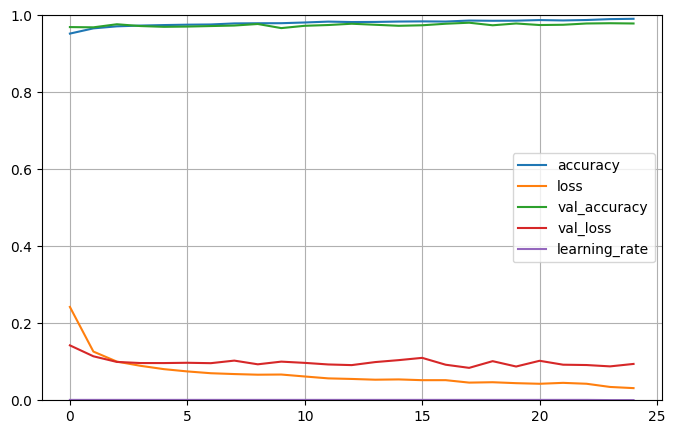

In [53]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

In [54]:
total_loss, total_accuracy = WaD_model.evaluate(
    X_test_prepared, 
    y_test
)

print(f"Total Loss: {total_loss}")
print(f"Total Accuracy: {total_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.9871 - loss: 0.0455
Total Loss: 0.0526813343167305
Total Accuracy: 0.9833444356918335


## **Enhancing Model Performance: Batch Normalization and Regularization**
To improve our model's stability and generalization, let's incorporate **Batch Normalization** and apply **$\ell_1$ and $\ell_2$ Regularization**. These techniques will help to prevent overfitting and ensure better convergence during training.

### Batch Normalization (BN)
- Normalizes the inputs to each hidden layer by zero-centering and scaling them. It then uses two learnable parameters per layer to scale and shift the results, allowing the model to learn the optimal input mean and variance.

- During testing, Keras uses a moving average of the input means and standard deviations, calculated during training, to normalize inputs when making predictions.

### $\ell_1$ Regularization (Lasso)
- Adds the absolute value of weights to the loss function.
- Encourages sparsity, forcing many weights to zero, making it useful for feature selection.


### $\ell_2$ Regularization (Ridge)
- Adds the squared value of weights to the loss function.
- Penalizes large weights, encouraging more even weight distribution without forcing them to zero.

Now we also need to include a @property call. This is for an issue we would have faced later when we want to doing a RandomizedSearchCV to fine tune our model. We will be using scikeras `KerasRegressor`, which is a thin wrapper around our Keras model to act like a regular Scikit-Learn regressor which we can fit(), score(), and predict() with. 

However, our subclassed ImprovedWideAndDeepModel already has an "output" property, and scikeras expects our model to have an "outputs" attribute. To fix this, we need to make ImprovedWideAndDeepModel behave like a typical Keras model by having an "outputs" attribute, so we override the output property to return a list of outputs (as expected by scikeras).

In [80]:
@keras.utils.register_keras_serializable()
class ImprovedWideAndDeepModel(keras.Model):
    def __init__(self, n_hidden=3, n_neurons=[100, 50, 16], l1_reg=0.001, l2_reg=0.001, **kwargs):
        super().__init__(**kwargs)
        self.n_hidden = n_hidden
        self.n_neurons = n_neurons
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.regularizer = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
        self.kernel_initializer = 'he_normal'
        self.input_shape_value = (9,)
        self.activation_function = LeakyReLU(alpha=0.01)

        # Input Layer
        self.input_layer = keras.layers.InputLayer(input_shape=self.input_shape_value)
        
        # Hidden Layers (Deep Path)
        self.hidden_layers = [
            keras.layers.Dense(n_neurons[i], activation=None, 
                               kernel_regularizer=self.regularizer, # L1/L2 Regularizer
                               kernel_initializer=self.kernel_initializer)
            for i in range(n_hidden)
        ]

        #Batch Normalization
        self.batch_norm_layers = [BatchNormalization() for _ in range(n_hidden+1)]


        #Batch Normalization
        self.batch_norm_final = [BatchNormalization() for _ in range(n_hidden+1)]
        
        # Concatenate Layer (Wide Path)
        self.concat = keras.layers.Concatenate()
        
        # Final Hidden Layer
        self.hidden_final = keras.layers.Dense(32, activation=self.activation_function, 
                                               kernel_initializer=self.kernel_initializer)
        
        # Output Layer
        self.target_type_output = keras.layers.Dense(6, activation="softmax", name="target_type_output", 
                                                     kernel_initializer=self.kernel_initializer)

    def call(self, inputs):
        x = inputs
        for layer, batch_norm in zip(self.hidden_layers, self.batch_norm_layers):
            x = layer(x)   
            x = batch_norm(x)             
            x = self.activation_function(x) 
        inputs_norm = self.batch_norm_final[0](inputs)
        concat = self.concat([inputs_norm, x])
        hidden_final = self.hidden_final(concat)
        output = self.target_type_output(hidden_final)
        
        return output

    def get_config(self):
        config = super().get_config() 
        config.update({
            "n_hidden": self.n_hidden,
            "n_neurons": self.n_neurons,
            "l1_reg": self.l1_reg,
            "l2_reg": self.l2_reg
        })
        return config
    
    @property
    def outputs(self):
        return [self.target_type_output]

In [81]:
WaD_model_improved = ImprovedWideAndDeepModel(
    n_hidden=3,  
    n_neurons=[100, 50, 16],  
    l1_reg=0.001,  
    l2_reg=0.001
)

In [82]:
WaD_model_improved.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [83]:
WaD_model_improved.save("WaD_model_improved.keras")

In [84]:
WaD_model_improved.summary()

Model: "improved_wide_and_deep_model_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ leaky_re_lu_65 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_layer_65 (InputLayer)     │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_504         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_505         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_506         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_507         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_508         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_509         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_510         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_511         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_65 (Concatenate)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ target_type_output (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [85]:
WaD_model_improved.layers

[<LeakyReLU name=leaky_re_lu_65, built=True>,
 <InputLayer name=input_layer_65, built=True>,
 <Dense name=dense_260, built=False>,
 <Dense name=dense_261, built=False>,
 <Dense name=dense_262, built=False>,
 <BatchNormalization name=batch_normalization_504, built=False>,
 <BatchNormalization name=batch_normalization_505, built=False>,
 <BatchNormalization name=batch_normalization_506, built=False>,
 <BatchNormalization name=batch_normalization_507, built=False>,
 <BatchNormalization name=batch_normalization_508, built=False>,
 <BatchNormalization name=batch_normalization_509, built=False>,
 <BatchNormalization name=batch_normalization_510, built=False>,
 <BatchNormalization name=batch_normalization_511, built=False>,
 <Concatenate name=concatenate_65, built=False>,
 <Dense name=dense_263, built=False>,
 <Dense name=target_type_output, built=False>]

In [86]:
root_logdir = os.path.join(os.curdir, "Logs", "Model 2")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

os.makedirs(run_logdir, exist_ok=True)

In [87]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("WaD_model_improved.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)


history = WaD_model_improved.fit(
    X_train_prepared,
    y_train,
    epochs=200,
    validation_data=(
        X_valid_prepared,
        y_valid
    ),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb, reduce_lr]
)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7686 - loss: 2.0921 - val_accuracy: 0.9667 - val_loss: 1.2471 - learning_rate: 0.0010
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9667 - loss: 1.1717 - val_accuracy: 0.9680 - val_loss: 0.9636 - learning_rate: 0.0010
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9690 - loss: 0.8993 - val_accuracy: 0.9627 - val_loss: 0.7918 - learning_rate: 0.0010
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9733 - loss: 0.7114 - val_accuracy: 0.9720 - val_loss: 0.6258 - learning_rate: 0.0010
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9733 - loss: 0.5746 - val_accuracy: 0.9700 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9732 - loss: 0.4706 - val_accuracy: 0.9700 - val_loss: 0.4150 - learning_rate: 0.0010
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9755 - 

In [88]:

WaD_model_improved = keras.models.load_model("WaD_model_improved.keras", custom_objects={"ImprovedWideAndDeepModel": ImprovedWideAndDeepModel, "LeakyReLU": LeakyReLU})

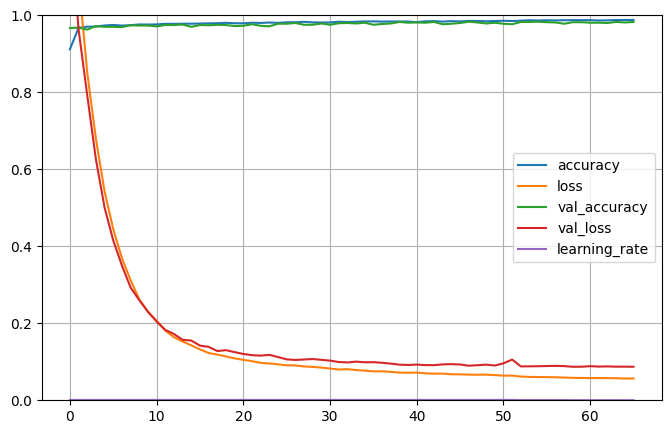

In [89]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

In [90]:
total_loss, total_accuracy = WaD_model_improved.evaluate(
    X_test_prepared, 
    y_test
)

print(f"Total Loss: {total_loss}")
print(f"Total Accuracy: {total_accuracy}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9882 - loss: 0.0502
Total Loss: 0.0591450072824955
Total Accuracy: 0.9846768975257874


Our model did improve slightly, with a lower Total Loss and a higher Total Accuracy. But we can go further by doing a RandomizedSearchCV to fine tune our model. 

## **Fine-Tuning Our Model: Hyperparameter Optimization**

To fine-tune our model, we'll use SciKeras' `KerasRegressor` to wrap our model, enabling us to use it as an estimator for hyperparameter optimization with `RandomizedSearchCV`.

We'll perform a randomized search to identify the optimal values for key hyperparameters, including the number of hidden layers, the number of neurons per layer, the $\ell_1$ and $\ell_2$ regularization strengths, and the learning rate.

When using SciKeras, it's important to prefix model parameters with `model__` in the `param_distribs` dictionary. This ensures that `RandomizedSearchCV` correctly identifies them as arguments for the `build_WaD_model()` function.


In [91]:
def build_WaD_model(n_hidden=3, n_neurons=[100, 50, 16], l1_reg=0.001, l2_reg=0.001, learning_rate=0.001):
    model = ImprovedWideAndDeepModel(n_hidden=n_hidden, 
                             n_neurons=n_neurons, 
                             l1_reg=l1_reg,  
                             l2_reg=l2_reg)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [92]:
keras_reg = KerasRegressor(model=build_WaD_model, epochs=200, batch_size=32, verbose=1)

In [93]:
param_distribs = {
    "model__n_hidden": [3],  
    "model__n_neurons": [    
        [50, 32, 16],     
        [100, 50, 16],    
        [150, 75, 25],  
        [200, 100, 32],
    ],
    "model__l1_reg": [0.01, 0.005, 0.001],           
    "model__l2_reg": [0.01, 0.005, 0.001],           
    "model__learning_rate": [0.01, 0.005, 0.001]        
}

rnd_search_cv = RandomizedSearchCV(
    estimator=keras_reg,
    param_distributions=param_distribs,
    n_iter=20,  
    cv=3,       
    verbose=1,
    refit=False
)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

rnd_search_cv.fit(
    X_train_prepared,
    y_train,
    validation_data=(
        X_valid_prepared,
        y_valid
    ),
    callbacks=[early_stopping_cb, reduce_lr]
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Epoch 1/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9338 - loss: 4.0722 - val_accuracy: 0.9667 - val_loss: 0.4296
Epoch 2/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9614 - loss: 0.3099 - val_accuracy: 0.9694 - val_loss: 0.1282
Epoch 3/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9649 - loss: 0.1315 - val_accuracy: 0.9687 - val_loss: 0.1150
Epoch 4/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9713 - loss: 0.1080 - val_accuracy: 0.9714 - val_loss: 0.1136
Epoch 5/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9724 - loss: 0.1041 - val_accuracy: 0.9700 - val_loss: 0.1052
Epoch 6/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9759 - loss: 0.0963 - val_accuracy: 0.9727 - val_loss: 0.1076
Epoch 7/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9778 - loss: 0.0859 - val_accuracy: 0.9780 - val_loss: 0.1095
Epoch 8/200
146/146 ━━━━━━━━━

In [ ]:
rnd_search_cv.best_params_

{'model__n_neurons': [200, 100, 32],
 'model__n_hidden': 3,
 'model__learning_rate': 0.01,
 'model__l2_reg': 0.001,
 'model__l1_reg': 0.005}

Using RandomizedSearchCV, we found that our best hyperparameters. We can rebuild our ImprovedWideAndDeepModel using these hyperparameters to create our final model.

## **Final Model: Training and Saving the Optimized Model**

After performing hyperparameter tuning, we’ve identified the best parameters for our model. Let's now create the final version of our **Improved Wide and Deep Model** using the optimal values for the number of hidden layers, neurons, regularization strengths, and learning rate.

In [ ]:
best_params = rnd_search_cv.best_params_

final_model = ImprovedWideAndDeepModel(
    n_hidden=best_params['model__n_hidden'], 
    n_neurons=best_params['model__n_neurons'], 
    l1_reg=best_params['model__l1_reg'],  
    l2_reg=best_params['model__l2_reg']
)

final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_params['model__learning_rate']),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

final_model.save("WaD_model_final.keras")

In [ ]:
root_logdir = os.path.join(os.curdir, "Logs", "Model 3")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

os.makedirs(run_logdir, exist_ok=True)

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("WaD_model_final.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

history = final_model.fit(
    X_train_prepared,
    y_train,
    epochs=200,
    validation_data=(X_valid_prepared, y_valid),
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9472 - loss: 4.4752 - val_accuracy: 0.9674 - val_loss: 0.2493 - learning_rate: 0.0100
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9691 - loss: 0.2463 - val_accuracy: 0.9674 - val_loss: 0.2516 - learning_rate: 0.0100
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.2506 - val_accuracy: 0.9680 - val_loss: 0.2524 - learning_rate: 0.0100
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9755 - loss: 0.2291 - val_accuracy: 0.9727 - val_loss: 0.2553 - learning_rate: 0.0100
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.2264 - val_accuracy: 0.9680 - val_loss: 0.2512 - learning_rate: 0.0100
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9755 - loss: 0.2252 - val_accuracy: 0.9760 - val_loss: 0.2368 - learning_rate: 0.0100
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.

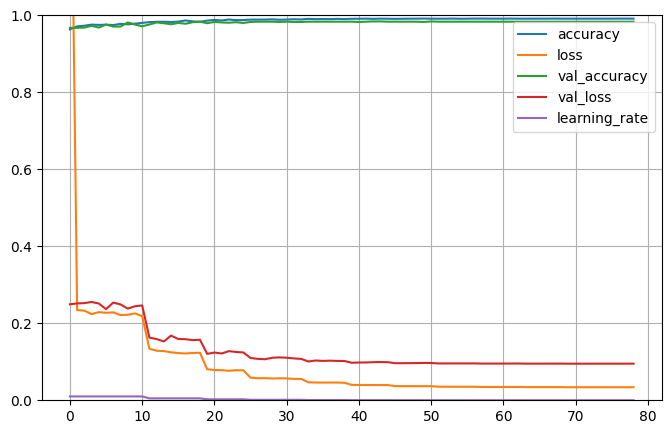

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

In [ ]:
total_loss, total_accuracy = final_model.evaluate(
    X_test_prepared, 
    y_test
)

print(f"Total Loss: {total_loss}")
print(f"Total Accuracy: {total_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0465
Total Loss: 0.05844792723655701
Total Accuracy: 0.9866755604743958


And our results did get slightly better with a higher total accuracy of 98.6% !